In [137]:
#all imports here

from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import nitime.analysis as nta
import nitime.timeseries as ts

In [3]:
#loading the data
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

paths = [make_path(i) for i in sub_list]
sub_data = [np.loadtxt(path) for path in paths]

### EDA on Single Subject

In [14]:
#get data for one subject
X = sub_data[1]
X.shape #(data points, brain regions)

(4800, 100)

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_39773/1701169756.py:1: DeprecationWarning: bias and ddof have no effect and are deprecated
  cov_matrix = np.corrcoef(X.T, bias=True)


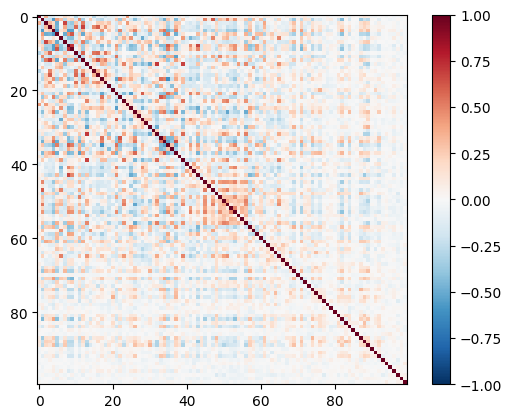

In [16]:
cov_matrix = np.corrcoef(X.T, bias=True)
plt.imshow(cov_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


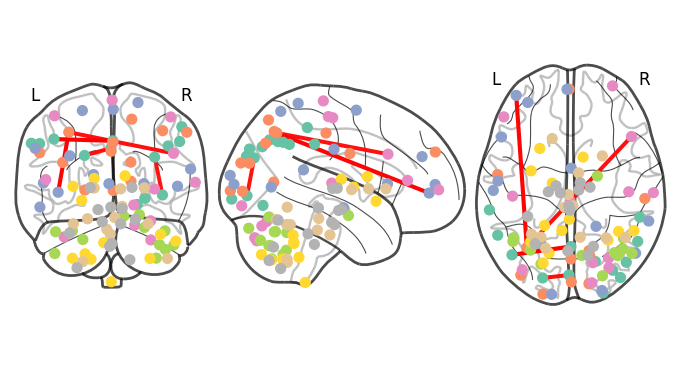

In [19]:
#lets plot it on the brain

atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)

plotting.plot_connectome(cov_matrix, atlas_coords, edge_threshold="99.9%")

In [206]:
#lets check the 99.9 percentile
def percentile(cov_matrix, percentile=99.9):
    cov_matrix = np.array(cov_matrix)
    iu = np.triu_indices(100, 1) #get the upper triangle and and offset it to not include the diagonal
    unique_cov = cov_matrix[iu]
    threshold = np.percentile(unique_cov, 99.9) #threshold for 99.9 percentile
    indices = np.where((cov_matrix >= threshold) & (cov_matrix <0.999))
    pairs = np.dstack(indices)
    unique_pairs = np.array(list({tuple(np.sort(row)) for row in pairs[0]}))
    strong_correlations = {(x, y):cov_matrix[x, y] for x, y in unique_pairs}
    return strong_correlations

In [207]:
percentile(cov_matrix)

{(np.int64(2), np.int64(7)): np.float64(0.6667103800859483),
 (np.int64(13), np.int64(39)): np.float64(0.6760047235995437),
 (np.int64(13), np.int64(32)): np.float64(0.706674930166747),
 (np.int64(8), np.int64(9)): np.float64(0.7218967428042317),
 (np.int64(3), np.int64(12)): np.float64(0.6808306576203431)}

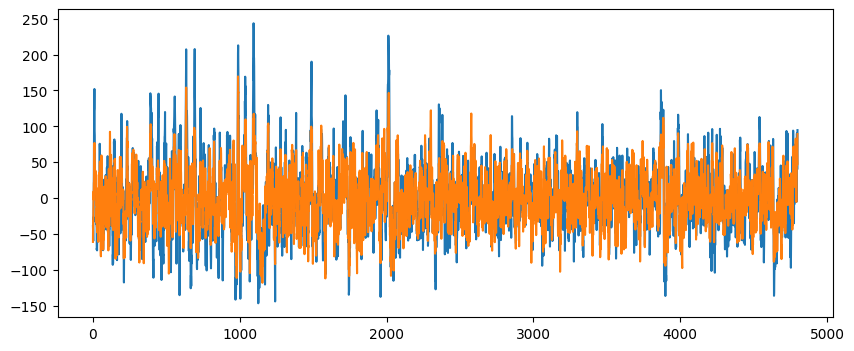

In [208]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[2])
plt.plot(X.T[7])


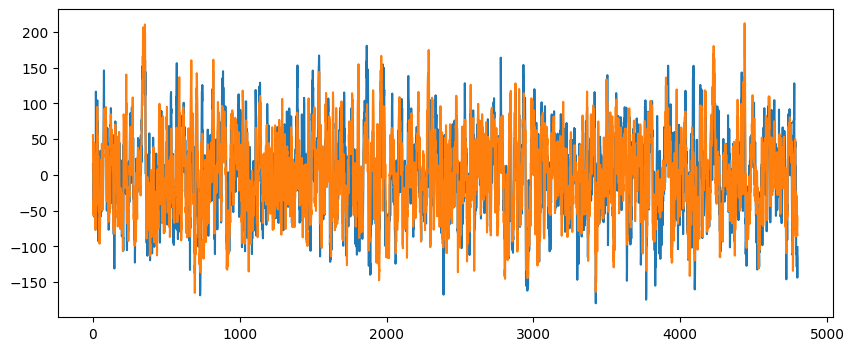

In [209]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[8])
plt.plot(X.T[9])

### Sliding Windows

In [210]:
def sliding_windows(data, num_windows, create_figure=False):
    len_window = 4800//num_windows
    window_matrices = []
    if create_figure:
        fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        sub_corr_matrix = np.corrcoef(lil_data.T)
        window_matrices.append(sub_corr_matrix) 
        if create_figure:
            img = axs[row][col].imshow(sub_corr_matrix, cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    if create_figure:
        fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

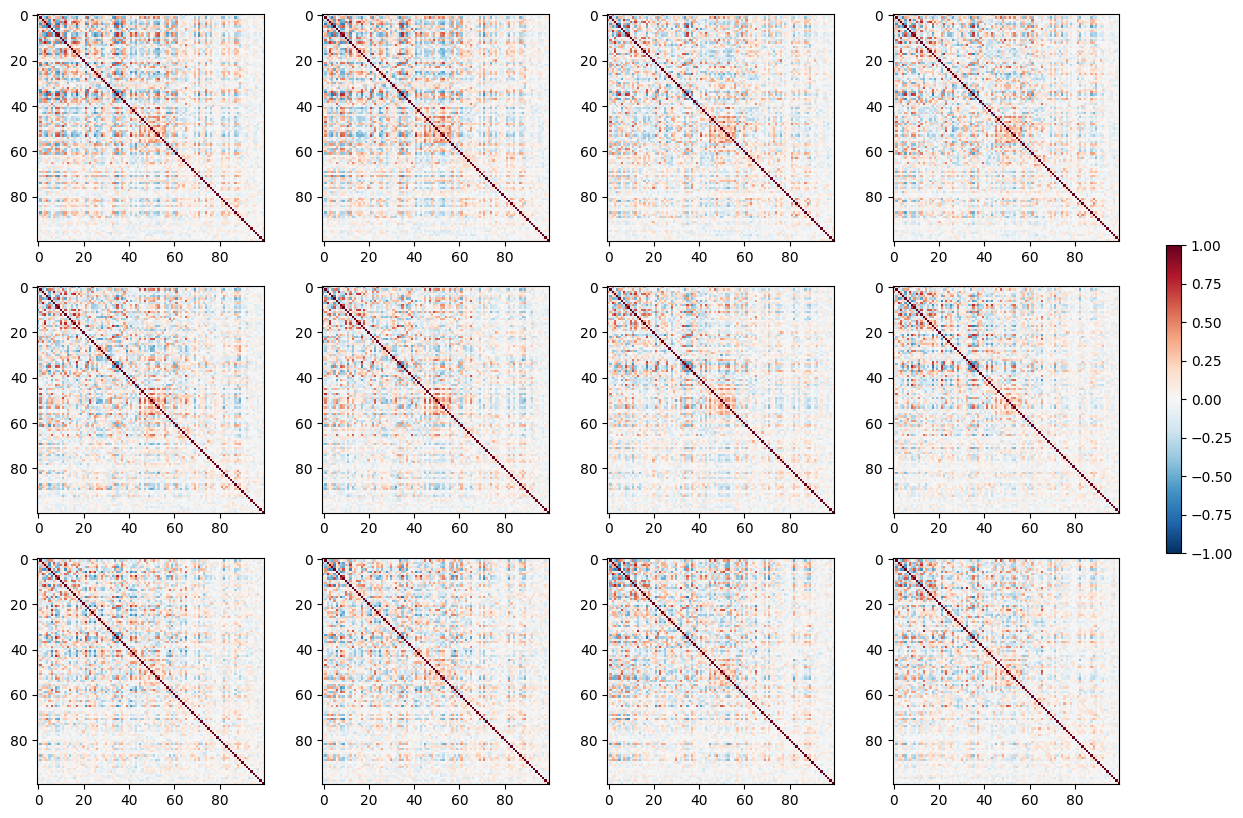

In [211]:
num_windows = 12
data = X
windows12 = sliding_windows(data, num_windows, True)

dict_keys([(np.int64(21), np.int64(53)), (np.int64(41), np.int64(53)), (np.int64(8), np.int64(9)), (np.int64(4), np.int64(34)), (np.int64(3), np.int64(12))])


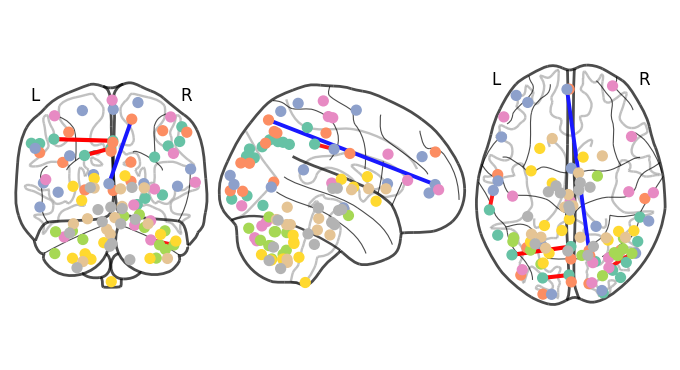

dict_keys([(np.int64(41), np.int64(53)), (np.int64(9), np.int64(35)), (np.int64(8), np.int64(35)), (np.int64(8), np.int64(9)), (np.int64(3), np.int64(12))])


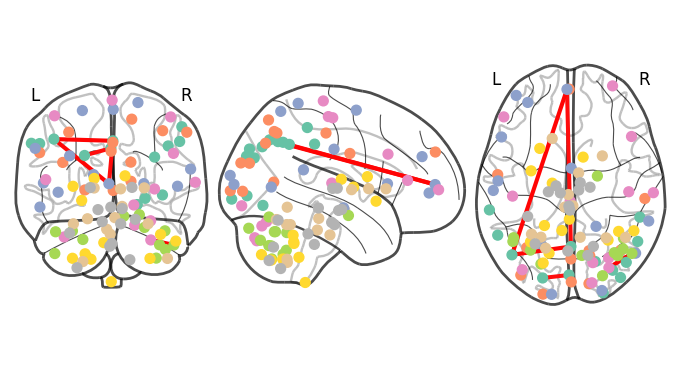

dict_keys([(np.int64(2), np.int64(7)), (np.int64(8), np.int64(35)), (np.int64(17), np.int64(22)), (np.int64(5), np.int64(35)), (np.int64(5), np.int64(9))])


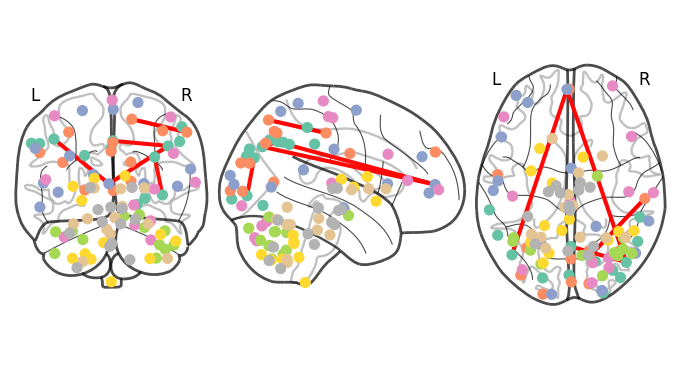

dict_keys([(np.int64(2), np.int64(7)), (np.int64(17), np.int64(22)), (np.int64(8), np.int64(9)), (np.int64(5), np.int64(35)), (np.int64(3), np.int64(12))])


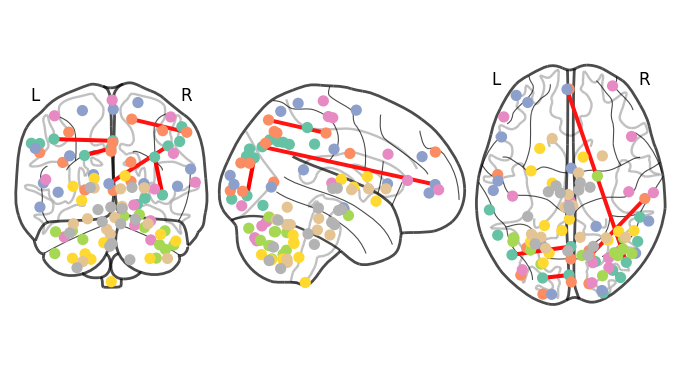

dict_keys([(np.int64(17), np.int64(33)), (np.int64(2), np.int64(7)), (np.int64(12), np.int64(16)), (np.int64(3), np.int64(16)), (np.int64(8), np.int64(9))])


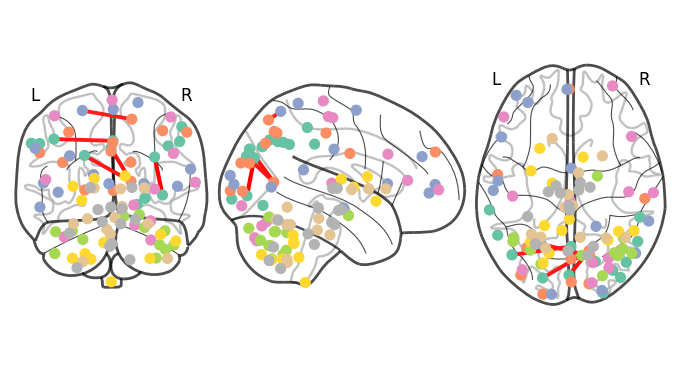

dict_keys([(np.int64(17), np.int64(33)), (np.int64(1), np.int64(47)), (np.int64(2), np.int64(7)), (np.int64(22), np.int64(33)), (np.int64(3), np.int64(16))])


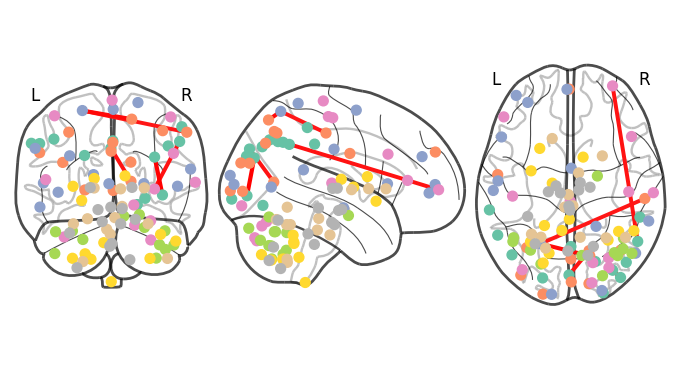

dict_keys([(np.int64(17), np.int64(33)), (np.int64(2), np.int64(7)), (np.int64(8), np.int64(35)), (np.int64(3), np.int64(12)), (np.int64(10), np.int64(12))])


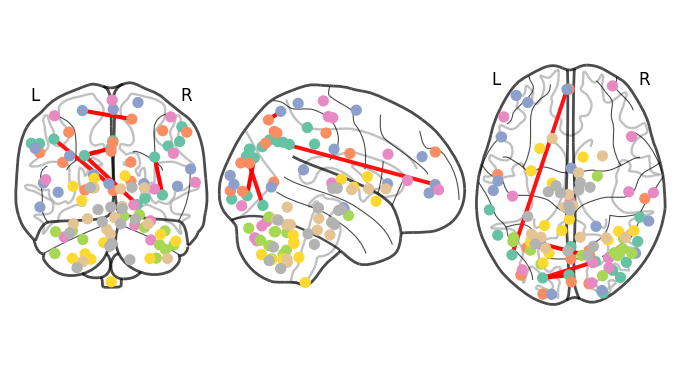

dict_keys([(np.int64(8), np.int64(43)), (np.int64(21), np.int64(35)), (np.int64(8), np.int64(35)), (np.int64(3), np.int64(12)), (np.int64(8), np.int64(21))])


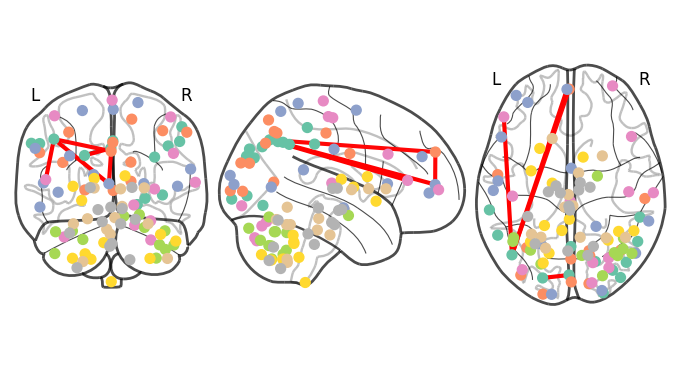

dict_keys([(np.int64(8), np.int64(43)), (np.int64(21), np.int64(41)), (np.int64(8), np.int64(35)), (np.int64(6), np.int64(23)), (np.int64(3), np.int64(12))])


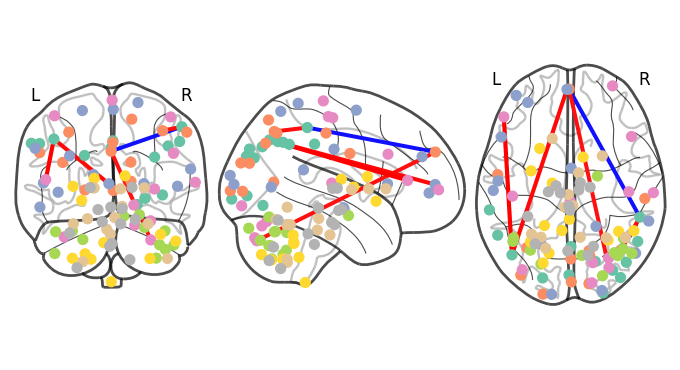

dict_keys([(np.int64(8), np.int64(43)), (np.int64(2), np.int64(7)), (np.int64(8), np.int64(35)), (np.int64(8), np.int64(9)), (np.int64(3), np.int64(12))])


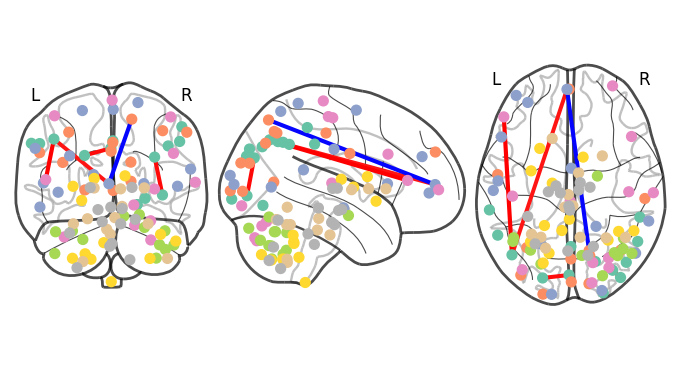

dict_keys([(np.int64(1), np.int64(47)), (np.int64(2), np.int64(7)), (np.int64(13), np.int64(32)), (np.int64(8), np.int64(9)), (np.int64(3), np.int64(12))])


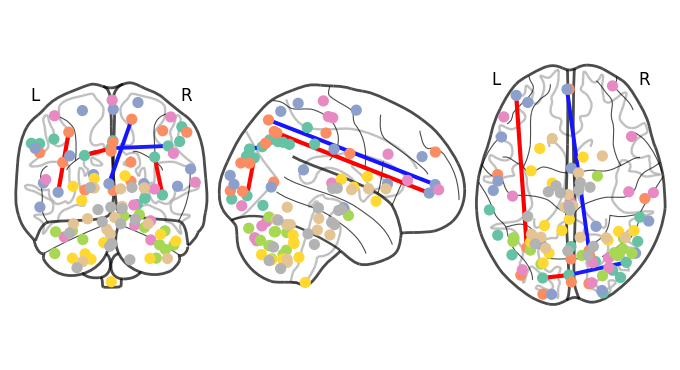

dict_keys([(np.int64(12), np.int64(16)), (np.int64(13), np.int64(39)), (np.int64(21), np.int64(28)), (np.int64(13), np.int64(32)), (np.int64(3), np.int64(12))])


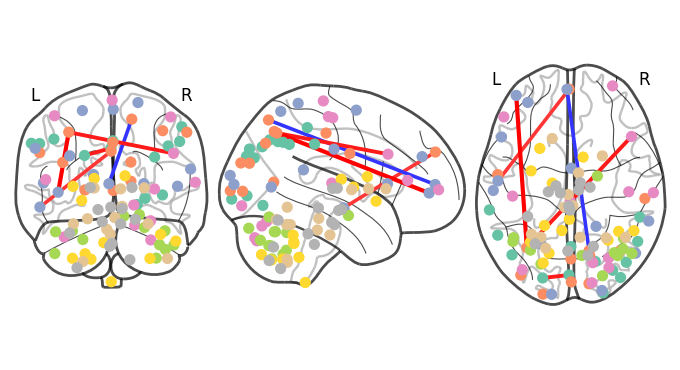

In [212]:
for mat in windows12:
    print(percentile(mat).keys())
    plotting.plot_connectome(mat, atlas_coords, edge_threshold="99.9%")
    plt.show()
#plot brain connectivities for each matrix

In [213]:
percentile(windows12[0])

{(np.int64(21), np.int64(53)): np.float64(0.7194837633958351),
 (np.int64(41), np.int64(53)): np.float64(0.7438987234942895),
 (np.int64(8), np.int64(9)): np.float64(0.8129228589713665),
 (np.int64(4), np.int64(34)): np.float64(0.7309707767668971),
 (np.int64(3), np.int64(12)): np.float64(0.782040352996986)}

In [ ]:
def plot_correlations_over_time(matrices, x, y):
    data = np.array(matrices)[:, x, y]
    data = pd.DataFrame({
        'x': range(1, len(data) + 1),  # Generate x-axis values (e.g., 1, 2, 3, ...)
        'y': data                     # Use the list for y-axis values
    })

    chart = alt.Chart(data).mark_line().encode(
    x=alt.X('x', title='Time Window'),
    y=alt.Y('y', title = 'Correlation'),
    tooltip=['x', 'y'],
    ).properties(title='Correlation over 12 windows for regions 2 x 7', )
    return chart



In [223]:
charts = []
for mat in windows12:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations:
        chart = plot_correlations_over_time(windows12, x, y)
        charts.append(chart)

combined_chart = alt.hconcat(*charts)
combined_chart


alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)
alt.Chart(...)


alt.HConcatChart(...)

In [190]:
import altair as alt

alt.Chart(data).mark_line().encode(
    x=alt.X('x', title='Time Window'),
    y=alt.Y('y', title = 'Correlation'),
    tooltip=['x', 'y'],
).properties(title='Correlation over 12 windows for regions 2 x 7', )

alt.Chart(...)

In [ ]:
import altair as alt

alt.Chart(data).mark_line().encode(
    x=alt.X('x', title='Time Window'),
    y=alt.Y('y', title = 'Correlation'),
    tooltip=['x', 'y'],
).properties(title='Correlation over 12 windows for regions 2 x 7', )

#### Coherence Analysis